In [0]:
import pandas as pd
import numpy as np

from scipy.spatial import distance
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import io
eps = np.finfo(float).eps

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### read data

In [0]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data.csv')

#### helper functions

In [0]:
def act_fun(function_name, delta,x):
    if function_name == "sigmoid":
        if delta==True:
            return delta_sigmoid(x)
        else:
            return sigmoid(x)
        
    elif function_name == "linear":
        if delta==True:
            return delta_linear(x)
        else:
            return linear(x)
        
def linear(x):
    return 0.1*x
  
def delta_linear(x):
#     print x.shape
    a = np.empty(x.shape)
    a.fill(0.1)
#     return np.ones(x.shape)
    return a

def sigmoid(x):
    x=-x
    return 1.0 / (1.0 + np.exp(x))
  
def delta_sigmoid(x):
    sig = sigmoid(x)
    del_sig = sig * (1.0 - sig)
    return del_sig
    
def delta_mean_square_error(y1, y):
    return (y1 - y)
  
def cross_entropy(predictions, targets, epsilon = 1e-12):
    predictions = np.clip(predictions, epsilon, 1.0 - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets * np.log(predictions + 1e-9))/N
    return ce

def model_acc(model):
    model.feed_forward(data)
    predicted_y = model.layer_output[-1]
    print np.all(np.isfinite(predicted_y)), np.all(np.isfinite(data)) 
    return np.linalg.norm(data - predicted_y)
#     return distance.euclidean(data, predicted_y)

In [5]:
Y = data.xAttack
data = data.drop('xAttack',axis=1)
data = StandardScaler().fit_transform(data)
# Y = data_train.iloc[:,0]

# unique_labels = np.unique(Y).tolist() 
# Y = one_hot_encode(Y, unique_labels)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### Neural Network class

In [0]:
class NeuralNetwork:
    def __init__(self,layers, neurons, features, batch_size, epochs, function_name, alpha=0.00001):
        
        self.weights = np.empty(layers + 1, dtype = object)
        for i in range(len(self.weights)):
            if i == layers:
                self.weights[i] = self.get_random_weights(neurons[i-1],features)
            elif i == 0:
                self.weights[i] = self.get_random_weights(features,neurons[i])
            else:
                self.weights[i] = self.get_random_weights(neurons[i-1],neurons[i])
        
        
        self.alpha = alpha
        self.layers = layers
        self.batch_size = batch_size
        self.epochs = epochs
        self.function_name = function_name
        
    
    def get_random_weights(self,a,b):
        return np.random.uniform(-np.sqrt(2.0 / a),np.sqrt(2.0 / a),(a, b))
        
    def update_weights(self,X,dw):    
        for i in range(layers + 1):
            if i == 0:
                dot = np.dot(X.T, dw[i])
                decrement = self.alpha * dot
                self.weights[i] -= decrement
            else:
                dot = np.dot(self.layer_output[i-1].T, dw[i])
                decrement = self.alpha * dot
                self.weights[i] -= decrement
    
    def back_prop(self,X, y):
        delta_weights = np.empty(layers + 1, dtype = object)
        for i in range(len(self.weights) - 1, -1, -1): 
            if i == self.layers:
                term1 = delta_mean_square_error(self.layer_output[-1], y)
                term2 = act_fun(self.function_name, True, self.layer_input[-1])
                delta_weights[i] = np.multiply(term1, term2)
            else: 
                term1 = np.dot(delta_weights[i+1], self.weights[i+1].T)
                term2 = act_fun(self.function_name,True,self.layer_input[i])
                delta_weights[i] = np.multiply(term1, term2)
                
        self.update_weights(X,delta_weights)    
        
    
    def feed_forward_encode(self,X):
        k = (self.layers+2)/2
        self.layer_input = np.empty(layers + 1, dtype = object)
        self.layer_output = np.empty(layers + 1, dtype = object)
        for i in range(k+1):
            if i == 0:
                self.layer_input[i] = np.dot(X, self.weights[i])
                self.layer_output[i] = act_fun(self.function_name, False, self.layer_input[i])
            else:
                self.layer_input[i] = np.dot(self.layer_output[i - 1], self.weights[i])
                self.layer_output[i] = act_fun(self.function_name, False, self.layer_input[i])
    
    def feed_forward(self,X):
        self.layer_input = np.empty(layers + 1, dtype = object)
        self.layer_output = np.empty(layers + 1, dtype = object)
        for i in range(len(self.weights)):
            if i == self.layers:
                self.layer_input[i] = np.dot(self.layer_output[i - 1], self.weights[i])
                self.layer_output[i] = act_fun(self.function_name,False,self.layer_input[i])
            elif i == 0:
                self.layer_input[i] = np.dot(X, self.weights[i])
                self.layer_output[i] = act_fun(self.function_name, False, self.layer_input[i])
            else:
                self.layer_input[i] = np.dot(self.layer_output[i - 1], self.weights[i])
                self.layer_output[i] = act_fun(self.function_name, False, self.layer_input[i])
        
    def batch_process(self,index,X,Y):
        start = index
        end = index + self.batch_size
        X_batch, Y_batch = X[start:end], Y[start:end]
        self.feed_forward(X_batch)
        self.back_prop(X_batch, Y_batch)
        ce = cross_entropy(self.layer_output[-1], Y_batch)
        return ce
    
    def train(self,X, y):
        for i in range(self.epochs):
            cost = 0
            for j in range(0, X.shape[0], self.batch_size):
                cost += self.batch_process(j,X,y)
                
            if i%50 == 0:    
                print str(i)+"   "+str(cost / self.batch_size)
            
    def test(self,test_x):
        k = (self.layers+2)/2
        self.feed_forward_encode(test_x)
        y_ = self.layer_output[k-1]
        return y_
                

#### calling neural network with all 3 activation functions

In [7]:

neurons = [14]
layers = len(neurons) 
batch_size = 500
epochs = 500
features = 29

# running for linear
model_l3 = NeuralNetwork(layers, neurons, features, batch_size, epochs, "linear", 0.001)
model_l3.train(data, data)
print model_acc(model_l3)

0   -5.636478515799176
50   -15.161893354960863
100   -15.164327673319589
150   -15.163464271174384
200   -15.163133153719006
250   -15.163000993570149
300   -15.16304324459456
350   -15.163185751886223
400   -15.163133141537017
450   -15.163205815277825
True True
256.4129930820416


In [8]:
data_linear_3 = model_l3.test(data)
data_linear_3 = pd.DataFrame( data_linear_3, columns=[ "new_dim"+str(i) for i in xrange(data_linear_3.shape[1]) ] )
print data_linear_3.head()

   new_dim0  new_dim1  new_dim2  new_dim3  new_dim4  new_dim5  new_dim6  \
0  0.537582 -1.303707  1.096948  0.940862 -0.111438 -0.074145 -0.523509   
1  0.702371  2.453477 -0.947554  1.278270 -3.327720 -1.189501  2.045086   
2  0.465056 -1.479982  1.067250  0.913703 -0.192759 -0.103572 -0.200336   
3  0.196487 -0.959637  0.258596  0.271876 -0.054497 -0.391295 -0.314567   
4 -0.941824  1.035037 -0.664420 -2.419959  1.895009  1.011479  0.761811   

   new_dim7  new_dim8  new_dim9  new_dim10  new_dim11  new_dim12  new_dim13  
0  0.384348 -0.408740 -0.628224  -0.746211  -0.103964   0.059739   1.480181  
1  1.426892  0.782931  1.249393   0.943718   1.643884  -0.806552  -1.853636  
2  0.449573 -0.234491 -0.701892  -0.611618  -0.221460   0.097382   1.614106  
3  0.288622  0.113202 -0.296850  -0.208965  -0.574999   0.492443   0.509816  
4 -0.401970  0.066980  1.130629   1.278920   0.567653  -0.550082  -0.944300  


In [9]:

neurons = [14]
layers = len(neurons) 
batch_size = 500
epochs = 500
features = 29

# running for sigmoid
model_nl3 = NeuralNetwork(layers, neurons, features, batch_size, epochs, "sigmoid", 0.001)
model_nl3.train(data, data)
print model_acc(model_nl3)

0   -0.9080030626254526
50   -5.31207957861555
100   -5.927730766439738
150   -6.257361441999802
200   -6.498011173138492
250   -6.688677755486561
300   -6.8299310484999385
350   -6.931956222035512
400   -7.010951238555525
450   -7.089467871663171
True True
681.6862455740853


In [10]:
data_non_linear_3 = model_nl3.test(data)
data_non_linear_3 = pd.DataFrame( data_non_linear_3, columns=[ "new_dim"+str(i) for i in xrange(data_non_linear_3.shape[1]) ] )
print data_non_linear_3.head()

   new_dim0  new_dim1  new_dim2  new_dim3  new_dim4  new_dim5  new_dim6  \
0  0.139829  0.870189  0.914046  0.473496  0.795263  0.140298  0.880405   
1  0.554716  0.003085  0.882892  0.209329  0.000668  0.900286  0.659720   
2  0.116137  0.923425  0.922607  0.532624  0.794570  0.168055  0.883412   
3  0.659246  0.974057  0.570738  0.698793  0.735136  0.683845  0.902932   
4  0.296291  0.026478  0.023054  0.256539  0.956099  0.869270  0.054139   

   new_dim7  new_dim8  new_dim9  new_dim10  new_dim11  new_dim12  new_dim13  
0  0.706135  0.208531  0.121233   0.645409   0.706233   0.633366   0.750271  
1  0.038023  0.963195  0.892203   0.992746   0.000142   0.024066   0.844948  
2  0.581080  0.179510  0.141019   0.661123   0.760299   0.530820   0.766448  
3  0.559136  0.540866  0.845875   0.532065   0.071136   0.894473   0.429629  
4  0.090185  0.920387  0.734961   0.066982   0.980234   0.975012   0.712591  


In [11]:

neurons = [20,14,20]
layers = len(neurons) 
batch_size = 500
epochs = 500
features = 29

# running for sigmoid and more layers
model_nl5 = NeuralNetwork(layers, neurons, features, batch_size, epochs, "sigmoid", 0.5)
model_nl5.train(data, data)
print model_acc(model_nl5)

0   0.0004974498738655608
50   6.400951682753764e-05
100   6.400951682753764e-05
150   6.400951682753764e-05
200   6.400951682753764e-05
250   6.400951682753764e-05
300   6.400951682753764e-05
350   6.400951682753764e-05
400   6.400951682753764e-05
450   6.400951682753764e-05
True True
851.4352588423759


In [12]:
data_non_linear_5 = model_nl5.test(data)
print data_non_linear_5.shape
data_non_linear_5 = pd.DataFrame( data_non_linear_5, columns=[ "new_dim"+str(i) for i in xrange(data_non_linear_5.shape[1]) ] )
print data_non_linear_5.head()

(24998, 14)
   new_dim0  new_dim1  new_dim2  new_dim3  new_dim4      new_dim5  \
0  0.874552  0.999933  0.001119  0.975437  0.599883  8.584186e-06   
1  0.840466  0.999994  0.000093  0.989648  0.378470  3.164617e-07   
2  0.876998  0.999943  0.000957  0.977415  0.579947  6.938100e-06   
3  0.848537  0.999953  0.000713  0.977973  0.575855  4.217575e-06   
4  0.683077  0.999995  0.000071  0.995073  0.539499  8.649886e-08   

       new_dim6  new_dim7  new_dim8  new_dim9  new_dim10     new_dim11  \
0  3.902834e-14  0.998770  0.999995  0.999966   0.999991  1.256733e-06   
1  1.429454e-16  0.999568  1.000000  0.999991   0.999999  5.249159e-08   
2  2.237298e-14  0.998958  0.999996  0.999969   0.999993  1.030066e-06   
3  1.425655e-14  0.999055  0.999996  0.999975   0.999995  8.524611e-07   
4  1.649064e-17  0.999715  1.000000  0.999998   1.000000  1.857128e-08   

   new_dim12     new_dim13  
0        1.0  1.260358e-07  
1        1.0  6.319510e-09  
2        1.0  1.001084e-07  
3        1.0

In [0]:
def plot_func(purity_dict):
    val = []
    label = []
    for k,v in purity_dict.items():
        val.append(v)
        label.append(k)

    print val,
    print label

    plt.pie( val, labels = label)
    plt.show()

In [0]:
def plot_all():
    print "K means : "
    plot_func(purity_dict_k_means)
    print "GMM : "
    plot_func(purity_dict_gmm)
    print "AGM : "
    plot_func(purity_dict_agm)


In [0]:
def purity(df,pred_Y,K):
    pred_Y = pd.DataFrame( pred_Y,columns=[ 'pred_Y' ] )
    df = pd.concat([df, pred_Y],axis=1)
    purity_dict = {}
    for i in xrange(K):
        sub_table = df[ df['pred_Y'] == i ]
        label, count = np.unique(sub_table['xAttack'],return_counts=True)
        mx_ind = np.argmax(count)
        purity_dict[i] = count[mx_ind] / float(len(sub_table))
    return purity_dict  



using compressed data from 3 layer linear activation autoencoder

In [0]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(data_linear_3)
cluster_k_means = kmeans.labels_

In [0]:
gmm = GaussianMixture(n_components=5).fit(data_linear_3)
cluster_gmm =  gmm.predict(data_linear_3)

In [0]:
agm = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single').fit(data_linear_3)
cluster_agm = agm.labels_

In [19]:
data_linear_3 = pd.concat([data_linear_3, Y], axis=1)

purity_dict_k_means = purity(data_linear_3,cluster_k_means,5)
purity_dict_gmm = purity(data_linear_3, cluster_gmm ,5)
purity_dict_agm = purity(data_linear_3, cluster_agm ,5)

print "Dimensionality reduced by autoencoder with linear activation and 3 layers"
print
print "k means : ",purity_dict_k_means
print "gmm : ",purity_dict_gmm
print "agm : ",purity_dict_agm

Dimensionality reduced by autoencoder with linear activation and 3 layers

k means :  {0: 0.8974595515185921, 1: 0.4603442456969288, 2: 0.9838126896950427, 3: 1.0, 4: 0.8070866141732284}
gmm :  {0: 0.5873015873015873, 1: 1.0, 2: 0.4561872909698997, 3: 0.8926121372031662, 4: 0.945010183299389}
agm :  {0: 0.5346752571131298, 1: 1.0, 2: 0.6666666666666666, 3: 1.0, 4: 1.0}


linear activation and 1 layer
K means : 
[0.8974595515185921, 0.4603442456969288, 0.9838126896950427, 1.0, 0.8070866141732284] [0, 1, 2, 3, 4]


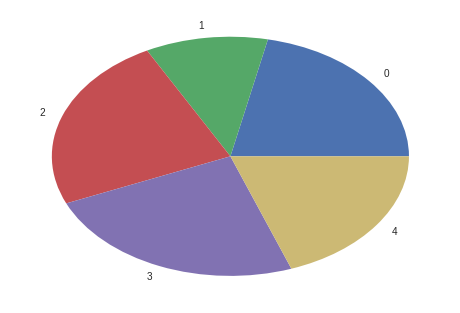

GMM : 
[0.5873015873015873, 1.0, 0.4561872909698997, 0.8926121372031662, 0.945010183299389] [0, 1, 2, 3, 4]


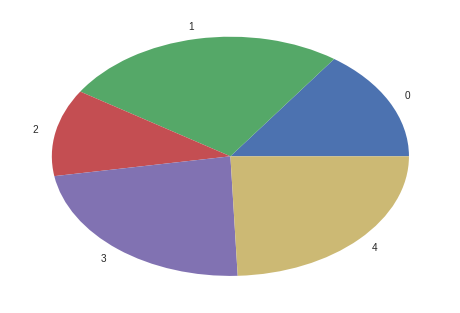

AGM : 
[0.5346752571131298, 1.0, 0.6666666666666666, 1.0, 1.0] [0, 1, 2, 3, 4]


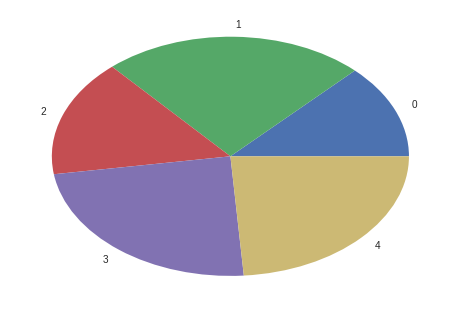

In [20]:
print "linear activation and 1 layer"
plot_all()

using compressed data from 3 layer non linear activation autoencoder

In [0]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(data_non_linear_3)
cluster_k_means = kmeans.labels_

In [0]:
gmm = GaussianMixture(n_components=5, n_init=10 ).fit(data_non_linear_3)
cluster_gmm =  gmm.predict(data_non_linear_3)

In [0]:
agm = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single').fit(data_non_linear_3)
cluster_agm = agm.labels_

In [24]:
data_non_linear_3 = pd.concat([data_non_linear_3, Y], axis=1)

purity_dict_k_means = purity(data_non_linear_3,cluster_k_means,5)
purity_dict_gmm = purity(data_non_linear_3, cluster_gmm ,5)
purity_dict_agm = purity(data_non_linear_3, cluster_agm ,5)

print "Dimensionality reduced by autoencoder with non linear activation and 3 layers"
print
print "k means : ",purity_dict_k_means
print "gmm : ",purity_dict_gmm
print "agm : ",purity_dict_agm

Dimensionality reduced by autoencoder with non linear activation and 3 layers

k means :  {0: 0.7194169703279542, 1: 0.9862258953168044, 2: 0.677145612343298, 3: 0.9863579474342928, 4: 0.4569051580698835}
gmm :  {0: 1.0, 1: 1.0, 2: 0.5538399024786672, 3: 0.853287641893339, 4: 0.5485021398002853}
agm :  {0: 0.5346083059934384, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


non linear activation and 1 layer
K means : 
[0.7194169703279542, 0.9862258953168044, 0.677145612343298, 0.9863579474342928, 0.4569051580698835] [0, 1, 2, 3, 4]


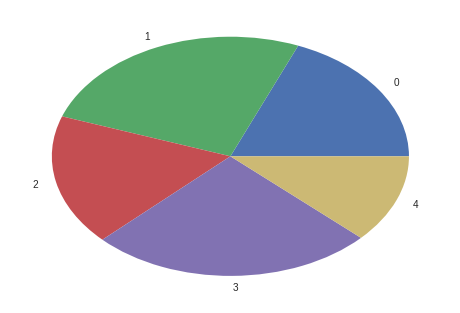

GMM : 
[1.0, 1.0, 0.5538399024786672, 0.853287641893339, 0.5485021398002853] [0, 1, 2, 3, 4]


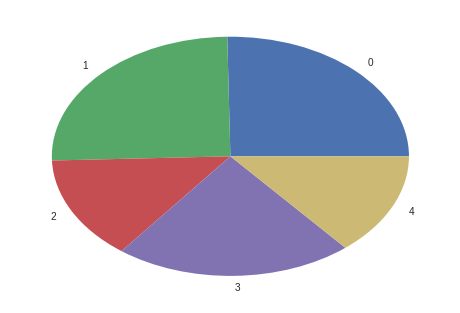

AGM : 
[0.5346083059934384, 1.0, 1.0, 1.0, 1.0] [0, 1, 2, 3, 4]


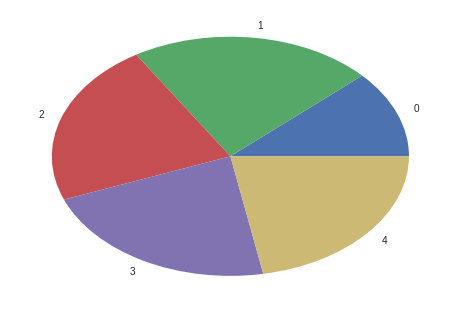

In [25]:
print "non linear activation and 1 layer"
plot_all()

using compressed data from 5 layer non linear activation autoencoder

In [0]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(data_non_linear_5)
cluster_k_means = kmeans.labels_

In [0]:
gmm = GaussianMixture(n_components=5, n_init=10 ).fit(data_non_linear_5)
cluster_gmm =  gmm.predict(data_non_linear_5)

In [0]:
agm = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single').fit(data_non_linear_5)
cluster_agm = agm.labels_

In [29]:
data_non_linear_5 = pd.concat([data_non_linear_5, Y], axis=1)

purity_dict_k_means = purity(data_non_linear_5,cluster_k_means,5)
purity_dict_gmm = purity(data_non_linear_5, cluster_gmm ,5)
purity_dict_agm = purity(data_non_linear_5, cluster_agm ,5)

print "Dimensionality reduced by autoencoder with non linear activation and 3 layers"
print
print "k means : ",purity_dict_k_means
print "gmm : ",purity_dict_gmm
print "agm : ",purity_dict_agm

Dimensionality reduced by autoencoder with non linear activation and 3 layers

k means :  {0: 0.8736600306278713, 1: 0.9175964511359054, 2: 0.5108614232209738, 3: 0.7275, 4: 0.8476034412126178}
gmm :  {0: 0.9899793692897141, 1: 0.8772204806687566, 2: 0.5760135135135135, 3: 0.7379652605459057, 4: 0.6971119981216248}
agm :  {0: 0.5344379077120103, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


non linear activation and 3 layer
K means : 
[0.8736600306278713, 0.9175964511359054, 0.5108614232209738, 0.7275, 0.8476034412126178] [0, 1, 2, 3, 4]


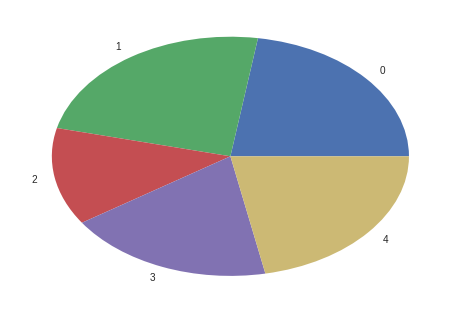

GMM : 
[0.9899793692897141, 0.8772204806687566, 0.5760135135135135, 0.7379652605459057, 0.6971119981216248] [0, 1, 2, 3, 4]


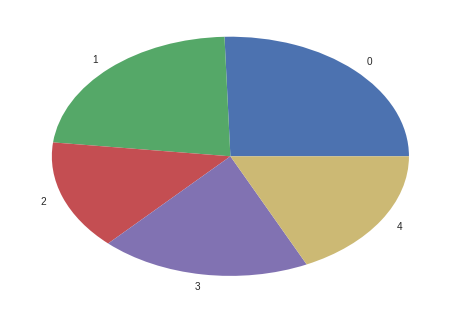

AGM : 
[0.5344379077120103, 1.0, 1.0, 1.0, 1.0] [0, 1, 2, 3, 4]


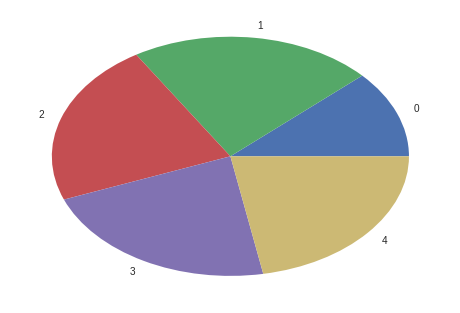

In [30]:
print "non linear activation and 3 layer"
plot_all()